# Bildklassifizierung auf Basis von Feed-Forward Neural Network Ensembles

Dieses Jupiter Notebook untersucht die Bildklassifikation durch Feed-Forward Neural Networks mit Ensembles auf Basis des Fashion-MNIST-Datensatzes. Durch den Einsatz von mehreren stimmberechtigten Modellen wird für jede Klasse ein Ensemble bestehend aus zehn Modellen erstellt.
Dabei entsteht ein Sicherheitsmaß, welches Aussagen über die Klassifikationssicherheit treffen kann.

Im folgenden werden die nötigen Python Bibliotheken importiert.

Diese müssen installiert werden:
- numpy
- scipy
- matplotlib

Die Installation erfolgt über den Befehl `!pip install numpy scipy matplotlib`.


In [59]:
import numpy
import scipy.special
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
# Definition der neuronalen Netzwerkklasse
class neuralNetwork:

    # Initialisierung des neuronalen Netzwerks
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # Anzahl der Nodes in jeder Input-, hidden und output layer festlegen
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # Gewichtsmatrizen, wih und who
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        # Lernrate
        self.lr = learningrate

        # Aktivierungsfunktion ist die Sigmoid-Funktion
        self.activation_function = lambda x: scipy.special.expit(x)

        pass

    # Trainieren des neuronalen Netzwerks
    def train(self, inputs_list, targets_list):
        # Inputs in ein 2D-Array umwandeln
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T

        # Signale in dem Hidden Layer berechnen
        hidden_inputs = numpy.dot(self.wih, inputs)
        # Signale berechnen, die aus dem Hidden Layer hervorgehen
        hidden_outputs = self.activation_function(hidden_inputs)

        # Signale in dem endgültigen Output Layer berechnen
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # Signale berechnen, die aus dem endgültigen Output Layer  hervorgehen
        final_outputs = self.activation_function(final_inputs)

        # Fehler in dem Output Layer ist (Ziel - Ist)
        output_errors = targets - final_outputs
        # Fehler in dem Hidden Layer ist der output_errors, aufgeteilt nach Gewichten, neu kombiniert an den Hidden Nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)

        # Gewichte für die Verbindungen zwischen den hidden und den Output Layers aktualisieren
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))

        # Gewichte für die Verbindungen zwischen den Input- und den Hidden Layern aktualisieren
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))

        pass

    # Abfragen des neuronalen Netzwerks
    def query(self, inputs_list):
        # Input List in ein 2D-Array umwandeln
        inputs = numpy.array(inputs_list, ndmin=2).T

        # Signale in die Hidden Layern berechnen
        hidden_inputs = numpy.dot(self.wih, inputs)
        # Signale berechnen, die aus dem Hidden Layer hervorgehen
        hidden_outputs = self.activation_function(hidden_inputs)

        # Signale in den endgültigen Output Layer berechnen
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # Signale berechnen, die aus dem endgültigen Output Layer hervorgehen
        final_outputs = self.activation_function(final_inputs)

        return final_outputs

In [85]:
# Anzahl an input, hidden und output nodes
input_nodes = 784
hidden_nodes = 15
output_nodes = 1
epochs = 10

# Lernrate
learning_rate = 0.05

# Erstelle Instanz des neuronalen Netzwerks
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)

In [86]:
with open("./data/fashion-mnist_test.csv", 'r') as test_data_file:
    test_data_list = test_data_file.readlines()[1:]

In [10]:
# Erstellen Sie eine Liste von 10 Ensembles, die jeweils 10 Modelle enthalten
ensembles = []
for _ in range(10):
    ensemble = []
    for i in range(10):
        ensemble.append(neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate))
    ensembles.append(ensemble)

In [11]:
for ensemble in ensembles:
    for i in range(10):
        for e in range(epochs):
            for record in training_data_list:
                all_values = record.split(',')
                inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
                target = numpy.array([0.99 if int(all_values[0]) == i else 0.01])
                ensemble[i].train(inputs, target)

In [ ]:
with open("./data/fashion-mnist_test.csv", 'r') as test_data_file:
    test_data_list = test_data_file.readlines()[1:]

In [12]:
# Initialize lists to store performance metrics
scorecard = []
test_confidences = []

# Go through all the records in the test data set
for record in test_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    # Correct answer is first value
    correct_label = int(all_values[0])
    inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    
    # Get predictions from all models in all ensembles
    ensemble_predictions = []
    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_predictions.extend(predicted_labels)
    
    if ensemble_predictions:
        # Get the most common prediction
        prediction = max(set(ensemble_predictions), key=ensemble_predictions.count)
        # Calculate confidence (number of votes for the prediction / total votes)
        confidence = ensemble_predictions.count(prediction) / len(ensemble_predictions)
        test_confidences.append(confidence)
        
        # Append 1 to scorecard for correct prediction, 0 for incorrect
        scorecard.append(1 if prediction == correct_label else 0)
    else:
        # Handle the case when no predictions were made
        test_confidences.append(0.0)  # Record zero confidence
        scorecard.append(0)  # Count as incorrect prediction

# Calculate the performance score
score = sum(scorecard) / len(scorecard)
print(f'Performance = {score}')

# Calculate average confidence
avg_confidence = sum(test_confidences) / len(test_confidences)
print(f'Average confidence = {avg_confidence:.4f}')

Performance = 0.876
Average confidence = 0.9477


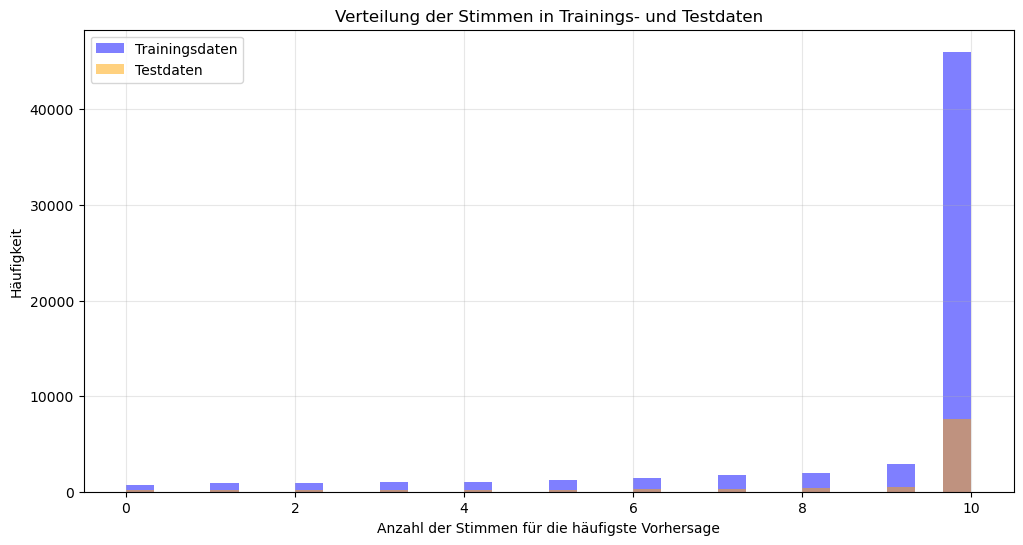

Durchschnittliche Stimmen in Trainingsdaten: 8.99
Durchschnittliche Stimmen in Testdaten: 8.95


In [26]:
# Initialize lists to store vote counts
train_vote_counts = []
test_vote_counts = []

# Analyze training data
for record in training_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:  # Ungültige Datensätze überspringen
        continue

    correct_label = int(all_values[0])
    inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    
    # Stimmen von allen Modellen in allen Ensembles sammeln
    ensemble_predictions = []
    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_predictions.extend(predicted_labels)
    
    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        votes = ensemble_predictions.count(most_common)
        train_vote_counts.append(votes)
    else:
        train_vote_counts.append(0)  # Null Stimmen hinzufügen, wenn keine Vorhersagen gemacht wurden

# Analyze test data
for record in test_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:  # Ungültige Datensätze überspringen
        continue

    correct_label = int(all_values[0])
    inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    
    # Stimmen von allen Modellen in allen Ensembles sammeln
    ensemble_predictions = []
    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_predictions.extend(predicted_labels)
    
    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        votes = ensemble_predictions.count(most_common)
        test_vote_counts.append(votes)
    else:
        test_vote_counts.append(0)  # Null Stimmen hinzufügen, wenn keine Vorhersagen gemacht wurden

# Verteilung der Stimmen visualisieren
plt.figure(figsize=(12, 6))
plt.hist(train_vote_counts, bins=30, alpha=0.5, label='Trainingsdaten', color='blue')
plt.hist(test_vote_counts, bins=30, alpha=0.5, label='Testdaten', color='orange')
plt.xlabel('Anzahl der Stimmen für die häufigste Vorhersage')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Stimmen in Trainings- und Testdaten')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistiken ausgeben
print(f'Durchschnittliche Stimmen in Trainingsdaten: {numpy.mean(train_vote_counts):.2f}')
print(f'Durchschnittliche Stimmen in Testdaten: {numpy.mean(test_vote_counts):.2f}')


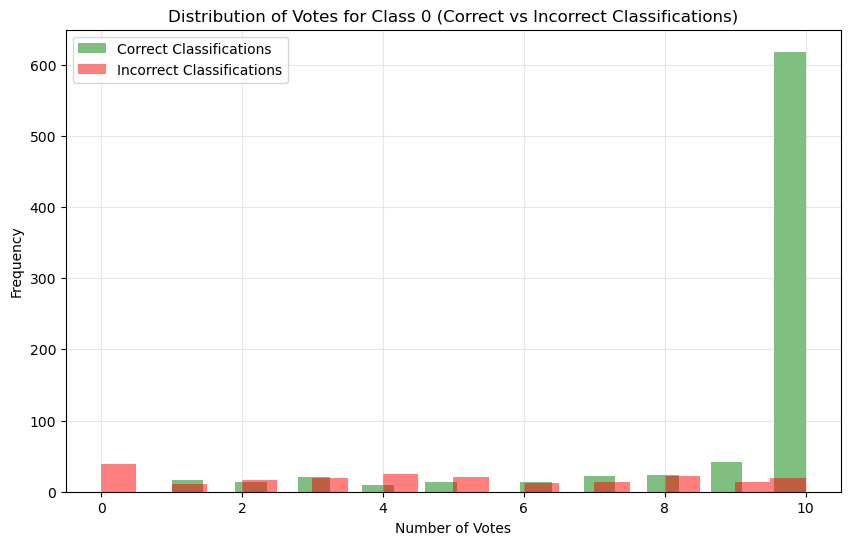

Average votes for correct classifications: 9.09
Average votes for incorrect classifications: 4.51


In [14]:
# Collect votes for class 0
correct_votes_0 = []
incorrect_votes_0 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 0
    if correct_label == 0:
        if score == 1:  # Correct classification
            correct_votes_0.append(votes)
        else:  # Incorrect classification
            incorrect_votes_0.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_0, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_0, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 0 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_0):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_0):.2f}')

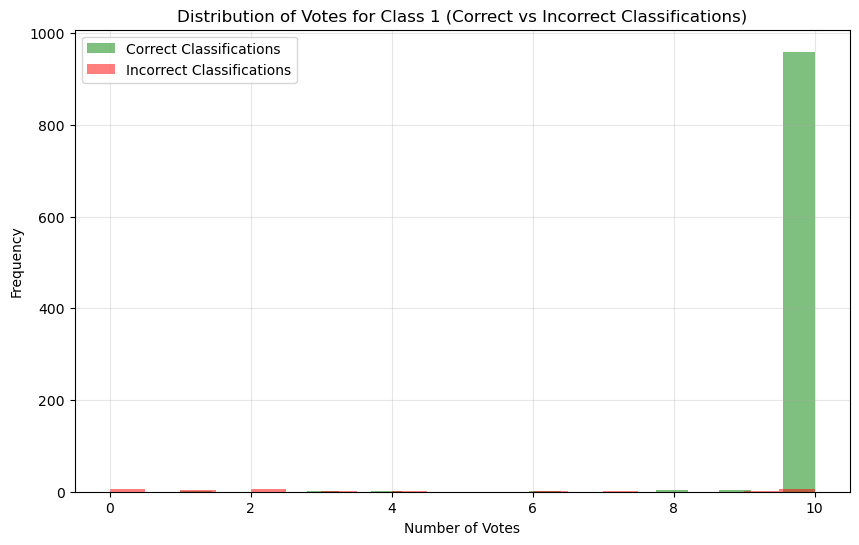

Average votes for correct classifications: 9.95
Average votes for incorrect classifications: 3.85


In [15]:
# Collect votes for class 1
correct_votes = []
incorrect_votes = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 1
    if correct_label == 1:
        if score == 1:  # Correct classification
            correct_votes.append(votes)
        else:  # Incorrect classification
            incorrect_votes.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 1 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes):.2f}')

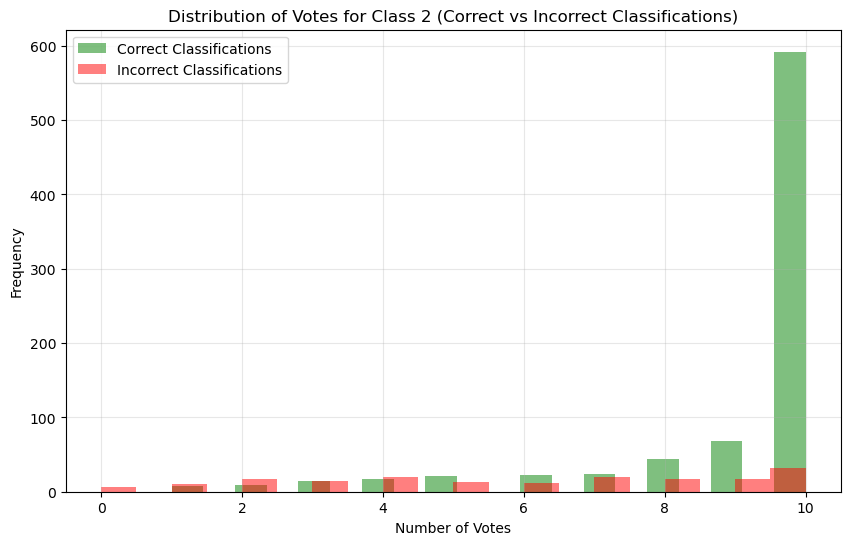

Average votes for correct classifications: 9.06
Average votes for incorrect classifications: 5.85


In [16]:
# Collect votes for class 2
correct_votes_2 = []
incorrect_votes_2 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 2
    if correct_label == 2:
        if score == 1:  # Correct classification
            correct_votes_2.append(votes)
        else:  # Incorrect classification
            incorrect_votes_2.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_2, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_2, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 2 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_2):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_2):.2f}')

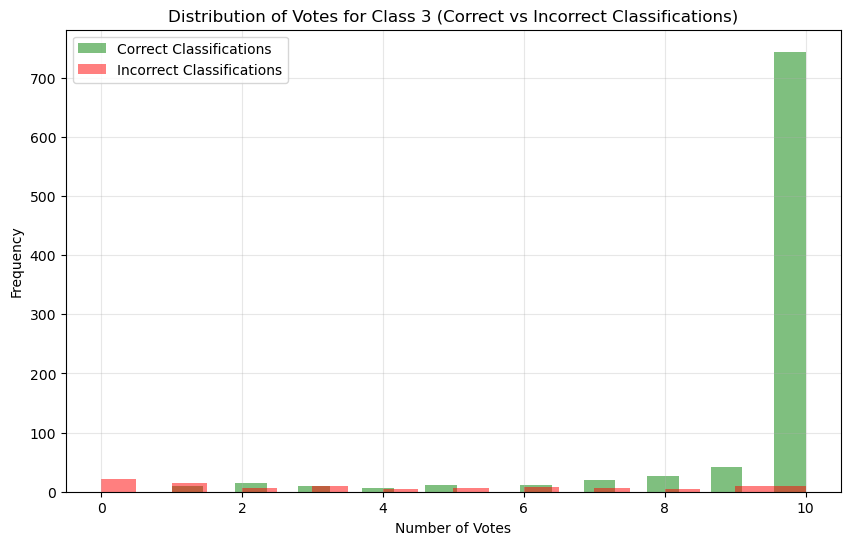

Average votes for correct classifications: 9.36
Average votes for incorrect classifications: 4.12


In [17]:
# Collect votes for class 3
correct_votes_3 = []
incorrect_votes_3 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 3
    if correct_label == 3:
        if score == 1:  # Correct classification
            correct_votes_3.append(votes)
        else:  # Incorrect classification
            incorrect_votes_3.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_3, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_3, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 3 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_3):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_3):.2f}')

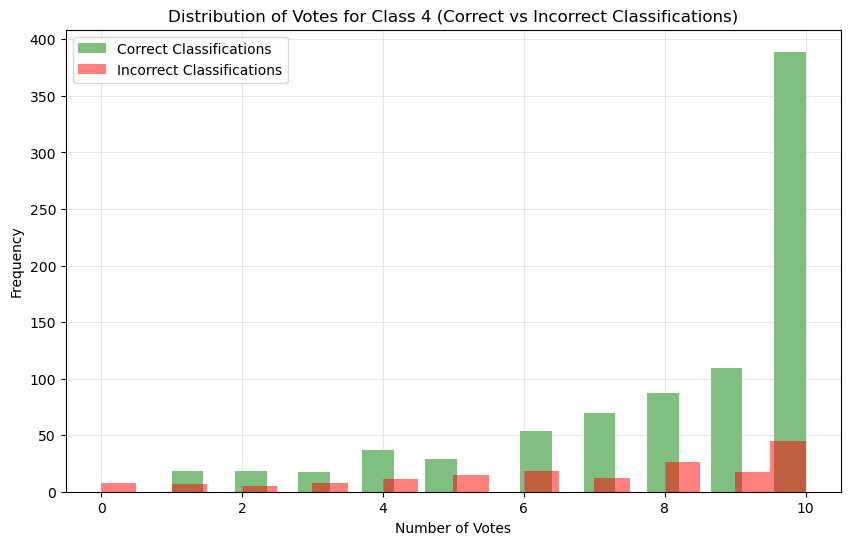

Average votes for correct classifications: 8.19
Average votes for incorrect classifications: 6.76


In [43]:
# Collect votes for class 4
correct_votes_4 = []
incorrect_votes_4 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 4
    if correct_label == 4:
        if score == 1:  # Correct classification
            correct_votes_4.append(votes)
        else:  # Incorrect classification
            incorrect_votes_4.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_4, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_4, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 4 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_4):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_4):.2f}')

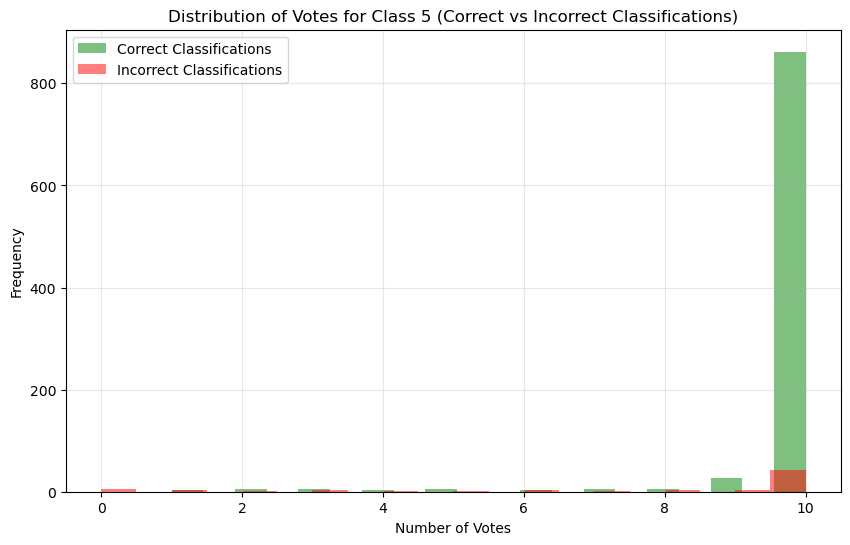

Average votes for correct classifications: 9.75
Average votes for incorrect classifications: 7.53


In [19]:
# Collect votes for class 5
correct_votes_5 = []
incorrect_votes_5 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 5
    if correct_label == 5:
        if score == 1:  # Correct classification
            correct_votes_5.append(votes)
        else:  # Incorrect classification
            incorrect_votes_5.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_5, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_5, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 5 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_5):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_5):.2f}')

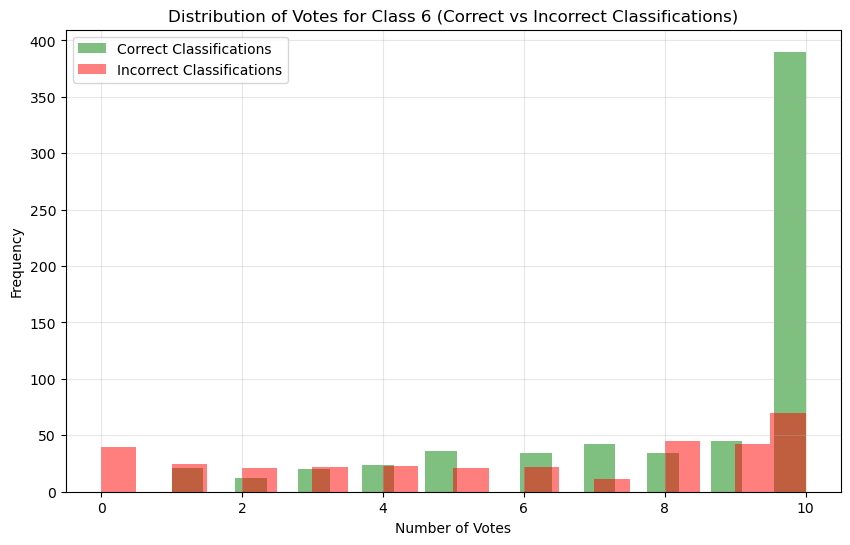

Average votes for correct classifications: 8.29
Average votes for incorrect classifications: 5.78


In [20]:
# Collect votes for class 6
correct_votes_6 = []
incorrect_votes_6 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 6
    if correct_label == 6:
        if score == 1:  # Correct classification
            correct_votes_6.append(votes)
        else:  # Incorrect classification
            incorrect_votes_6.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_6, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_6, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 6 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_6):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_6):.2f}')

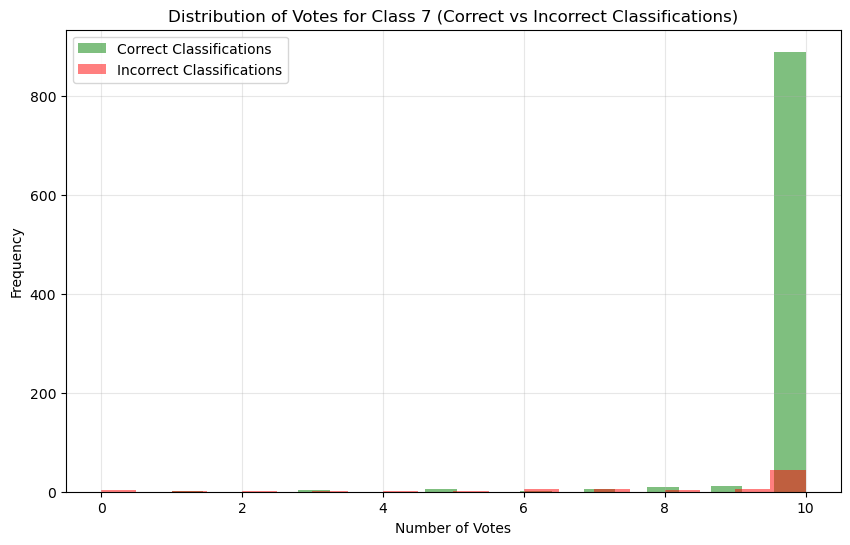

Average votes for correct classifications: 9.88
Average votes for incorrect classifications: 8.26


In [21]:
# Collect votes for class 7
correct_votes_7 = []
incorrect_votes_7 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 7
    if correct_label == 7:
        if score == 1:  # Correct classification
            correct_votes_7.append(votes)
        else:  # Incorrect classification
            incorrect_votes_7.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_7, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_7, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 7 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_7):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_7):.2f}')

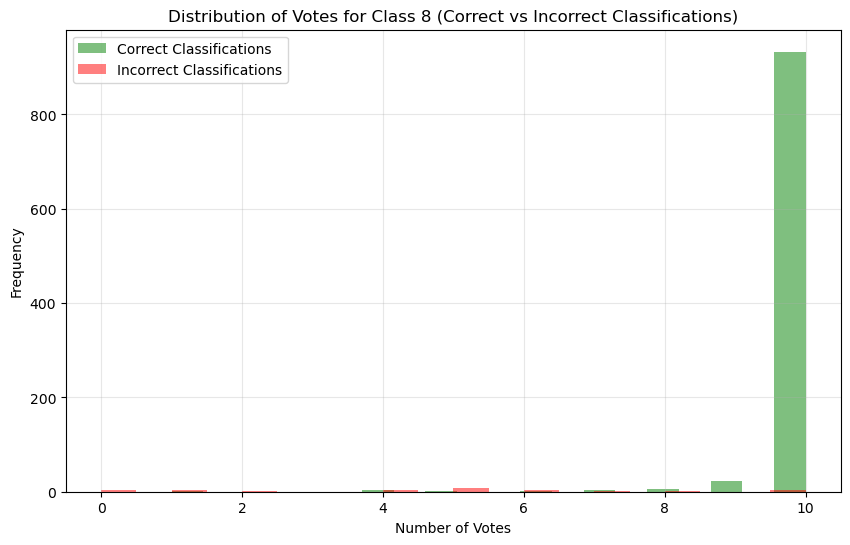

Average votes for correct classifications: 9.91
Average votes for incorrect classifications: 4.69


In [22]:
# Collect votes for class 8
correct_votes_8 = []
incorrect_votes_8 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 8
    if correct_label == 8:
        if score == 1:  # Correct classification
            correct_votes_8.append(votes)
        else:  # Incorrect classification
            incorrect_votes_8.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_8, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_8, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 8 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_8):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_8):.2f}')

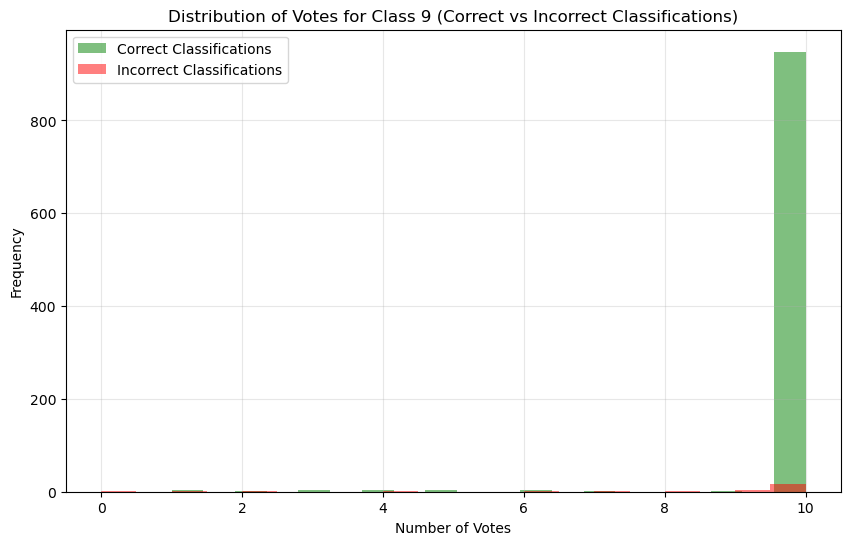

Average votes for correct classifications: 9.87
Average votes for incorrect classifications: 7.93


In [23]:
# Collect votes for class 9
correct_votes_9 = []
incorrect_votes_9 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 9
    if correct_label == 9:
        if score == 1:  # Correct classification
            correct_votes_9.append(votes)
        else:  # Incorrect classification
            incorrect_votes_9.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_9, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_9, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 9 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_9):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_9):.2f}')

<Figure size 2000x1500 with 0 Axes>

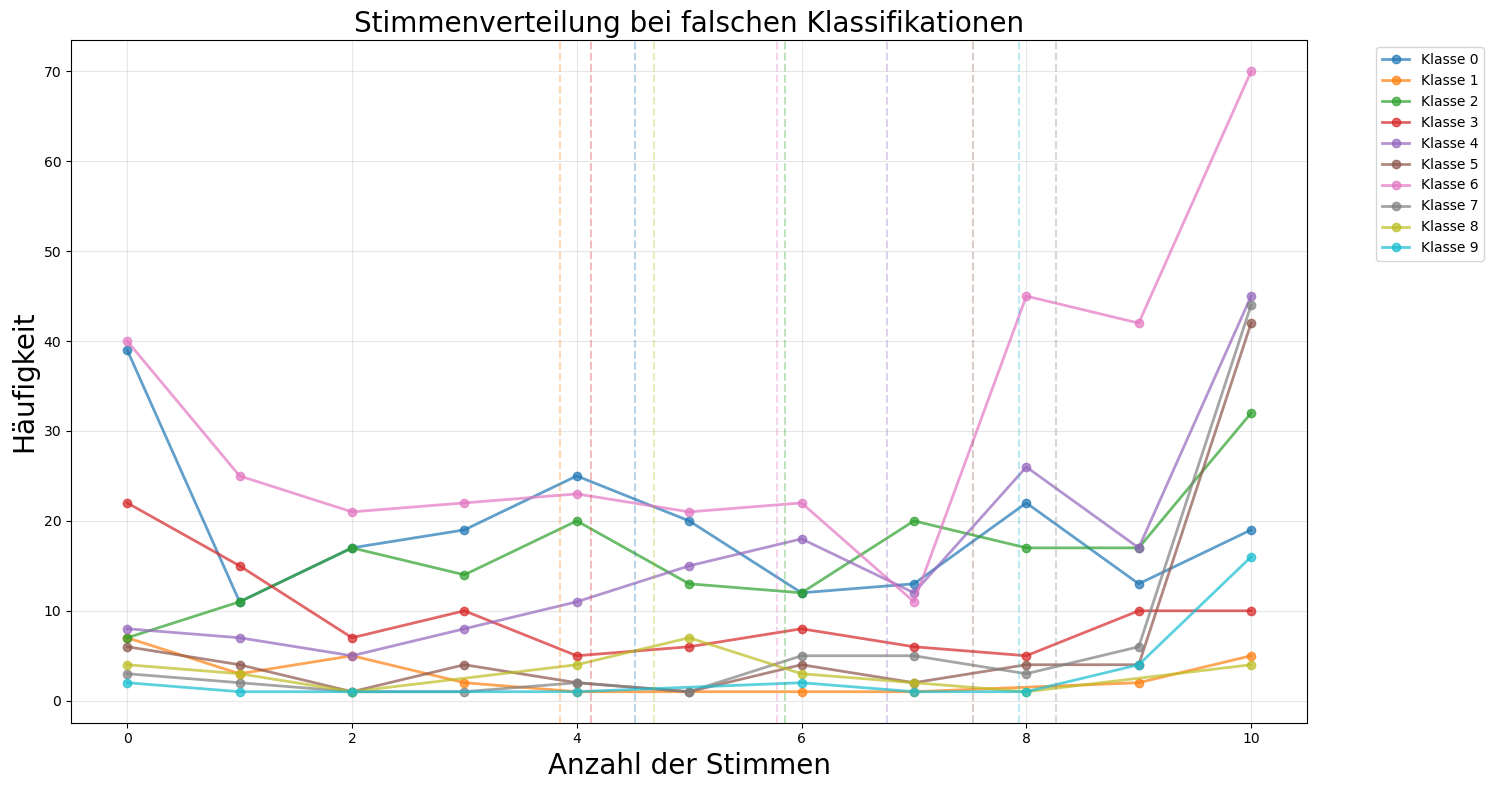


Statistiken (falsche Klassifikationen):
Klasse 0:
  Durchschnittliche Stimmen: 4.51
  Standardabweichung: 3.31
  Gesamtanzahl falsch klassifizierter Proben: 210

Klasse 1:
  Durchschnittliche Stimmen: 3.85
  Standardabweichung: 3.87
  Gesamtanzahl falsch klassifizierter Proben: 27

Klasse 2:
  Durchschnittliche Stimmen: 5.85
  Standardabweichung: 3.13
  Gesamtanzahl falsch klassifizierter Proben: 180

Klasse 3:
  Durchschnittliche Stimmen: 4.12
  Standardabweichung: 3.54
  Gesamtanzahl falsch klassifizierter Proben: 104

Klasse 4:
  Durchschnittliche Stimmen: 6.76
  Standardabweichung: 3.01
  Gesamtanzahl falsch klassifizierter Proben: 172

Klasse 5:
  Durchschnittliche Stimmen: 7.53
  Standardabweichung: 3.55
  Gesamtanzahl falsch klassifizierter Proben: 74

Klasse 6:
  Durchschnittliche Stimmen: 5.78
  Standardabweichung: 3.58
  Gesamtanzahl falsch klassifizierter Proben: 342

Klasse 7:
  Durchschnittliche Stimmen: 8.26
  Standardabweichung: 2.85
  Gesamtanzahl falsch klassifizierte

In [46]:
plt.figure(figsize=(20, 15))

# Daten für jede Klasse vorbereiten
classes = range(10)
class_votes_incorrect = [[] for _ in classes]

# Nur falsch klassifizierte Einträge sammeln
for record, votes, sc in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:
        continue
    correct_label = int(all_values[0])
    if sc == 0:  # 0 bedeutet falsche Klassifikation
        class_votes_incorrect[correct_label].append(votes)

# Liniendiagramm für alle Klassen (nur falsche Klassifikationen)
plt.figure(figsize=(15, 8))
colors = plt.cm.tab10(numpy.linspace(0, 1, 10))

for i in classes:
    vote_counts = {}
    for vote in class_votes_incorrect[i]:
        vote_counts[vote] = vote_counts.get(vote, 0) + 1
    
    votes_sorted = sorted(vote_counts.keys())
    frequencies = [vote_counts[v] for v in votes_sorted]
    
    plt.plot(
        votes_sorted, frequencies,
        '-', linewidth=2, marker='o',
        label=f'Klasse {i}', color=colors[i], alpha=0.7
    )

plt.title('Stimmenverteilung bei falschen Klassifikationen', fontsize=20)
plt.xlabel('Anzahl der Stimmen', fontsize=20)
plt.ylabel('Häufigkeit', fontsize=20)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Mittlere Stimmenzahl pro Klasse als Linie einzeichnen
for i in classes:
    if class_votes_incorrect[i]:
        mean_votes = numpy.mean(class_votes_incorrect[i])
        plt.axvline(x=mean_votes, color=colors[i], linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiken für jede Klasse
print("\nStatistiken (falsche Klassifikationen):")
for i in classes:
    if class_votes_incorrect[i]:
        mean_votes = numpy.mean(class_votes_incorrect[i])
        std_votes = numpy.std(class_votes_incorrect[i])
        print(f"Klasse {i}:")
        print(f"  Durchschnittliche Stimmen: {mean_votes:.2f}")
        print(f"  Standardabweichung: {std_votes:.2f}")
        print(f"  Gesamtanzahl falsch klassifizierter Proben: {len(class_votes_incorrect[i])}\n")
    else:
        print(f"Klasse {i}: Keine falsch klassifizierten Proben gefunden.\n")


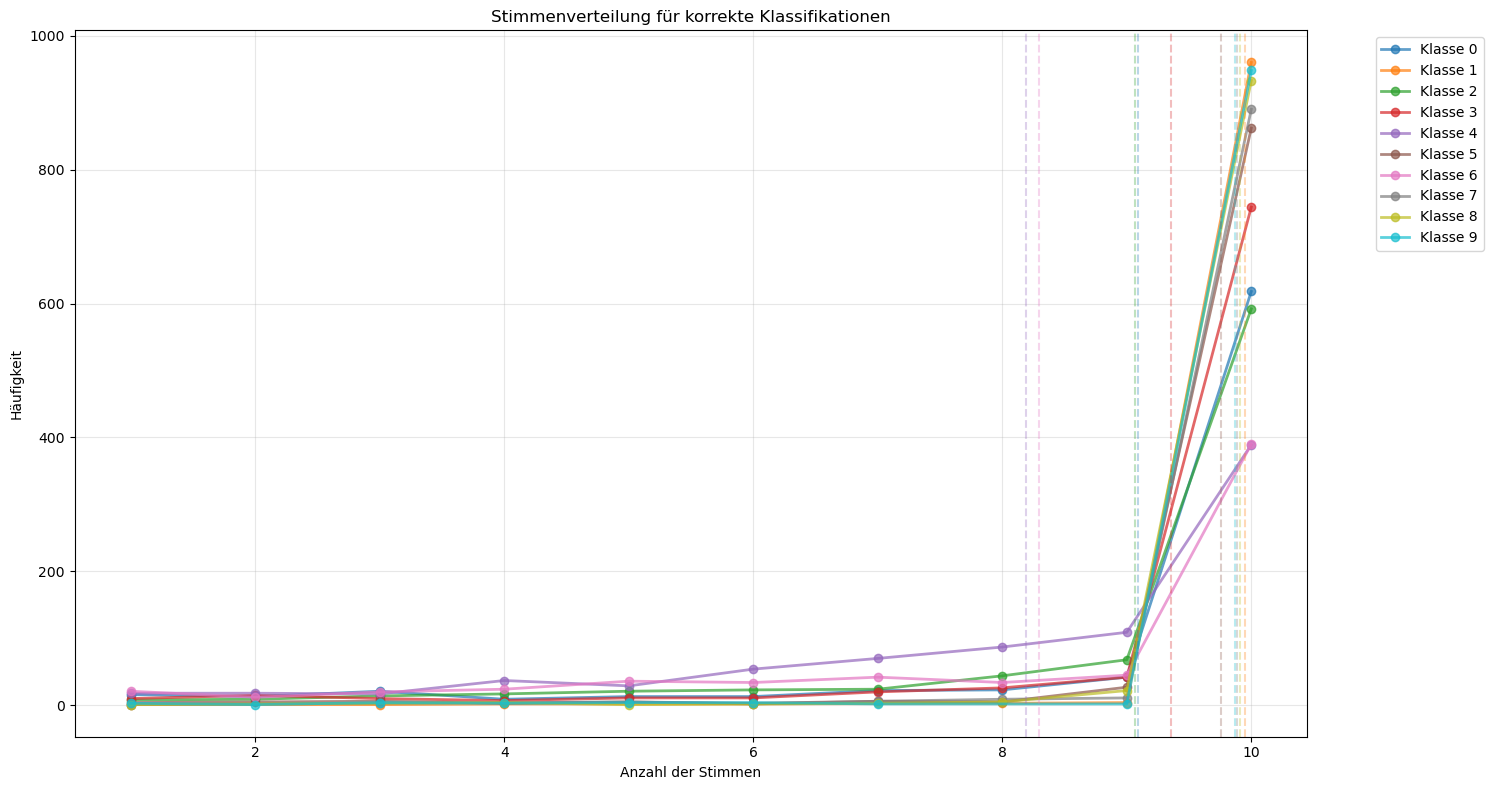


Stimmenstatistik (korrekte Klassifikationen):
Klasse 0:
  Durchschnittliche Stimmen: 9.09
  Standardabweichung: 2.16
  Gesamtanzahl richtig klassifizierter Proben: 790

Klasse 1:
  Durchschnittliche Stimmen: 9.95
  Standardabweichung: 0.50
  Gesamtanzahl richtig klassifizierter Proben: 973

Klasse 2:
  Durchschnittliche Stimmen: 9.06
  Standardabweichung: 1.96
  Gesamtanzahl richtig klassifizierter Proben: 820

Klasse 3:
  Durchschnittliche Stimmen: 9.36
  Standardabweichung: 1.81
  Gesamtanzahl richtig klassifizierter Proben: 896

Klasse 4:
  Durchschnittliche Stimmen: 8.19
  Standardabweichung: 2.39
  Gesamtanzahl richtig klassifizierter Proben: 828

Klasse 5:
  Durchschnittliche Stimmen: 9.75
  Standardabweichung: 1.17
  Gesamtanzahl richtig klassifizierter Proben: 926

Klasse 6:
  Durchschnittliche Stimmen: 8.29
  Standardabweichung: 2.58
  Gesamtanzahl richtig klassifizierter Proben: 658

Klasse 7:
  Durchschnittliche Stimmen: 9.88
  Standardabweichung: 0.71
  Gesamtanzahl richti

In [28]:
# Prepare data for each class
classes = range(10)
class_votes_correct = [[] for _ in classes]

# Collect votes only for correctly classified items
for record, votes, sc in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:
        continue
    correct_label = int(all_values[0])
    if sc == 1:  # 1 means correct classification
        class_votes_correct[correct_label].append(votes)

# Create line plot for all classes (only correct classifications)
plt.figure(figsize=(15, 8))
colors = plt.cm.tab10(numpy.linspace(0, 1, 10))

for i in classes:
    vote_counts = {}
    for vote in class_votes_correct[i]:
        vote_counts[vote] = vote_counts.get(vote, 0) + 1
    
    votes_sorted = sorted(vote_counts.keys())
    frequencies = [vote_counts[v] for v in votes_sorted]
    
    plt.plot(
        votes_sorted, frequencies,
        '-', linewidth=2, marker='o',
        label=f'Klasse {i}', color=colors[i], alpha=0.7
    )

plt.title('Stimmenverteilung für korrekte Klassifikationen')
plt.xlabel('Anzahl der Stimmen')
plt.ylabel('Häufigkeit')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add mean lines per class
for i in classes:
    if class_votes_correct[i]:
        mean_votes = numpy.mean(class_votes_correct[i])
        plt.axvline(x=mean_votes, color=colors[i], linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics for each class
print("\nStimmenstatistik (korrekte Klassifikationen):")
for i in classes:
    if class_votes_correct[i]:
        mean_votes = numpy.mean(class_votes_correct[i])
        std_votes = numpy.std(class_votes_correct[i])
        print(f"Klasse {i}:")
        print(f"  Durchschnittliche Stimmen: {mean_votes:.2f}")
        print(f"  Standardabweichung: {std_votes:.2f}")
        print(f"  Gesamtanzahl richtig klassifizierter Proben: {len(class_votes_correct[i])}\n")
    else:
        print(f"Klasse {i}: Keine richtig klassifizierten Proben gefunden.\n")


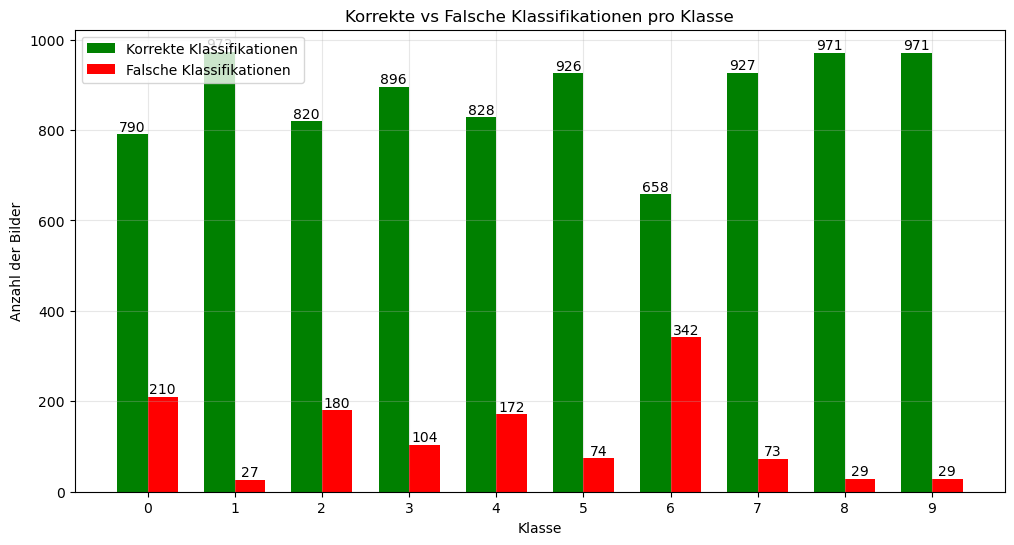


Genauigkeit pro Klasse:
Klasse 0: 79.00%
Klasse 1: 97.30%
Klasse 2: 82.00%
Klasse 3: 89.60%
Klasse 4: 82.80%
Klasse 5: 92.60%
Klasse 6: 65.80%
Klasse 7: 92.70%
Klasse 8: 97.10%
Klasse 9: 97.10%


In [29]:
# Calculate correct and incorrect classifications per class
class_results = {i: {'correct': 0, 'incorrect': 0} for i in range(10)}

# Go through all test data
for record, score in zip(test_data_list, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Ungültige Datensätze überspringen
        continue
        
    correct_label = int(all_values[0])
    if score == 1:
        class_results[correct_label]['correct'] += 1
    else:
        class_results[correct_label]['incorrect'] += 1

# Prepare data for plotting
classes = list(range(10))
correct_counts = [class_results[i]['correct'] for i in classes]
incorrect_counts = [class_results[i]['incorrect'] for i in classes]

# Create plot in German
plt.figure(figsize=(12, 6))
x = numpy.arange(len(classes))
width = 0.35

plt.bar(x - width/2, correct_counts, width, label='Korrekte Klassifikationen', color='green')
plt.bar(x + width/2, incorrect_counts, width, label='Falsche Klassifikationen', color='red')

plt.xlabel('Klasse')
plt.ylabel('Anzahl der Bilder')
plt.title('Korrekte vs Falsche Klassifikationen pro Klasse')
plt.xticks(x, classes)
plt.legend()

for i, v in enumerate(correct_counts):
    plt.text(i - width/2, v, str(v), ha='center', va='bottom')
for i, v in enumerate(incorrect_counts):
    plt.text(i + width/2, v, str(v), ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.show()

# Print accuracy per class in German
print("\nGenauigkeit pro Klasse:")
for i in classes:
    total = class_results[i]['correct'] + class_results[i]['incorrect']
    accuracy = (class_results[i]['correct'] / total) * 100 if total > 0 else 0
    print(f"Klasse {i}: {accuracy:.2f}%")


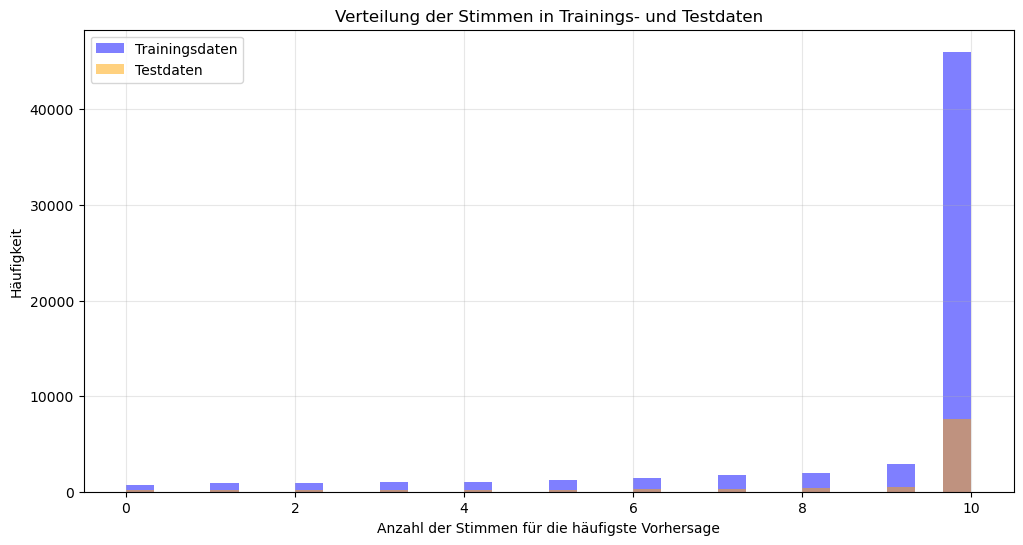

Durchschnittliche Stimmen in Trainingsdaten: 8.99
Durchschnittliche Stimmen in Testdaten: 8.95


In [30]:
# Initialize lists to store vote counts
train_vote_counts = []
test_vote_counts = []

# Analyze training data
for record in training_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:  # Ungültige Datensätze überspringen
        continue

    correct_label = int(all_values[0])
    inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    
    # Stimmen von allen Modellen in allen Ensembles sammeln
    ensemble_predictions = []
    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_predictions.extend(predicted_labels)
    
    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        votes = ensemble_predictions.count(most_common)
        train_vote_counts.append(votes)
    else:
        train_vote_counts.append(0)  # Null Stimmen hinzufügen, wenn keine Vorhersagen gemacht wurden

# Analyze test data
for record in test_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:  # Ungültige Datensätze überspringen
        continue

    correct_label = int(all_values[0])
    inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    
    # Stimmen von allen Modellen in allen Ensembles sammeln
    ensemble_predictions = []
    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_predictions.extend(predicted_labels)
    
    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        votes = ensemble_predictions.count(most_common)
        test_vote_counts.append(votes)
    else:
        test_vote_counts.append(0)  # Null Stimmen hinzufügen, wenn keine Vorhersagen gemacht wurden

# Verteilung der Stimmen visualisieren
plt.figure(figsize=(12, 6))
plt.hist(train_vote_counts, bins=30, alpha=0.5, label='Trainingsdaten', color='blue')
plt.hist(test_vote_counts, bins=30, alpha=0.5, label='Testdaten', color='orange')
plt.xlabel('Anzahl der Stimmen für die häufigste Vorhersage')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Stimmen in Trainings- und Testdaten')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistiken ausgeben
print(f'Durchschnittliche Stimmen in Trainingsdaten: {numpy.mean(train_vote_counts):.2f}')
print(f'Durchschnittliche Stimmen in Testdaten: {numpy.mean(test_vote_counts):.2f}')

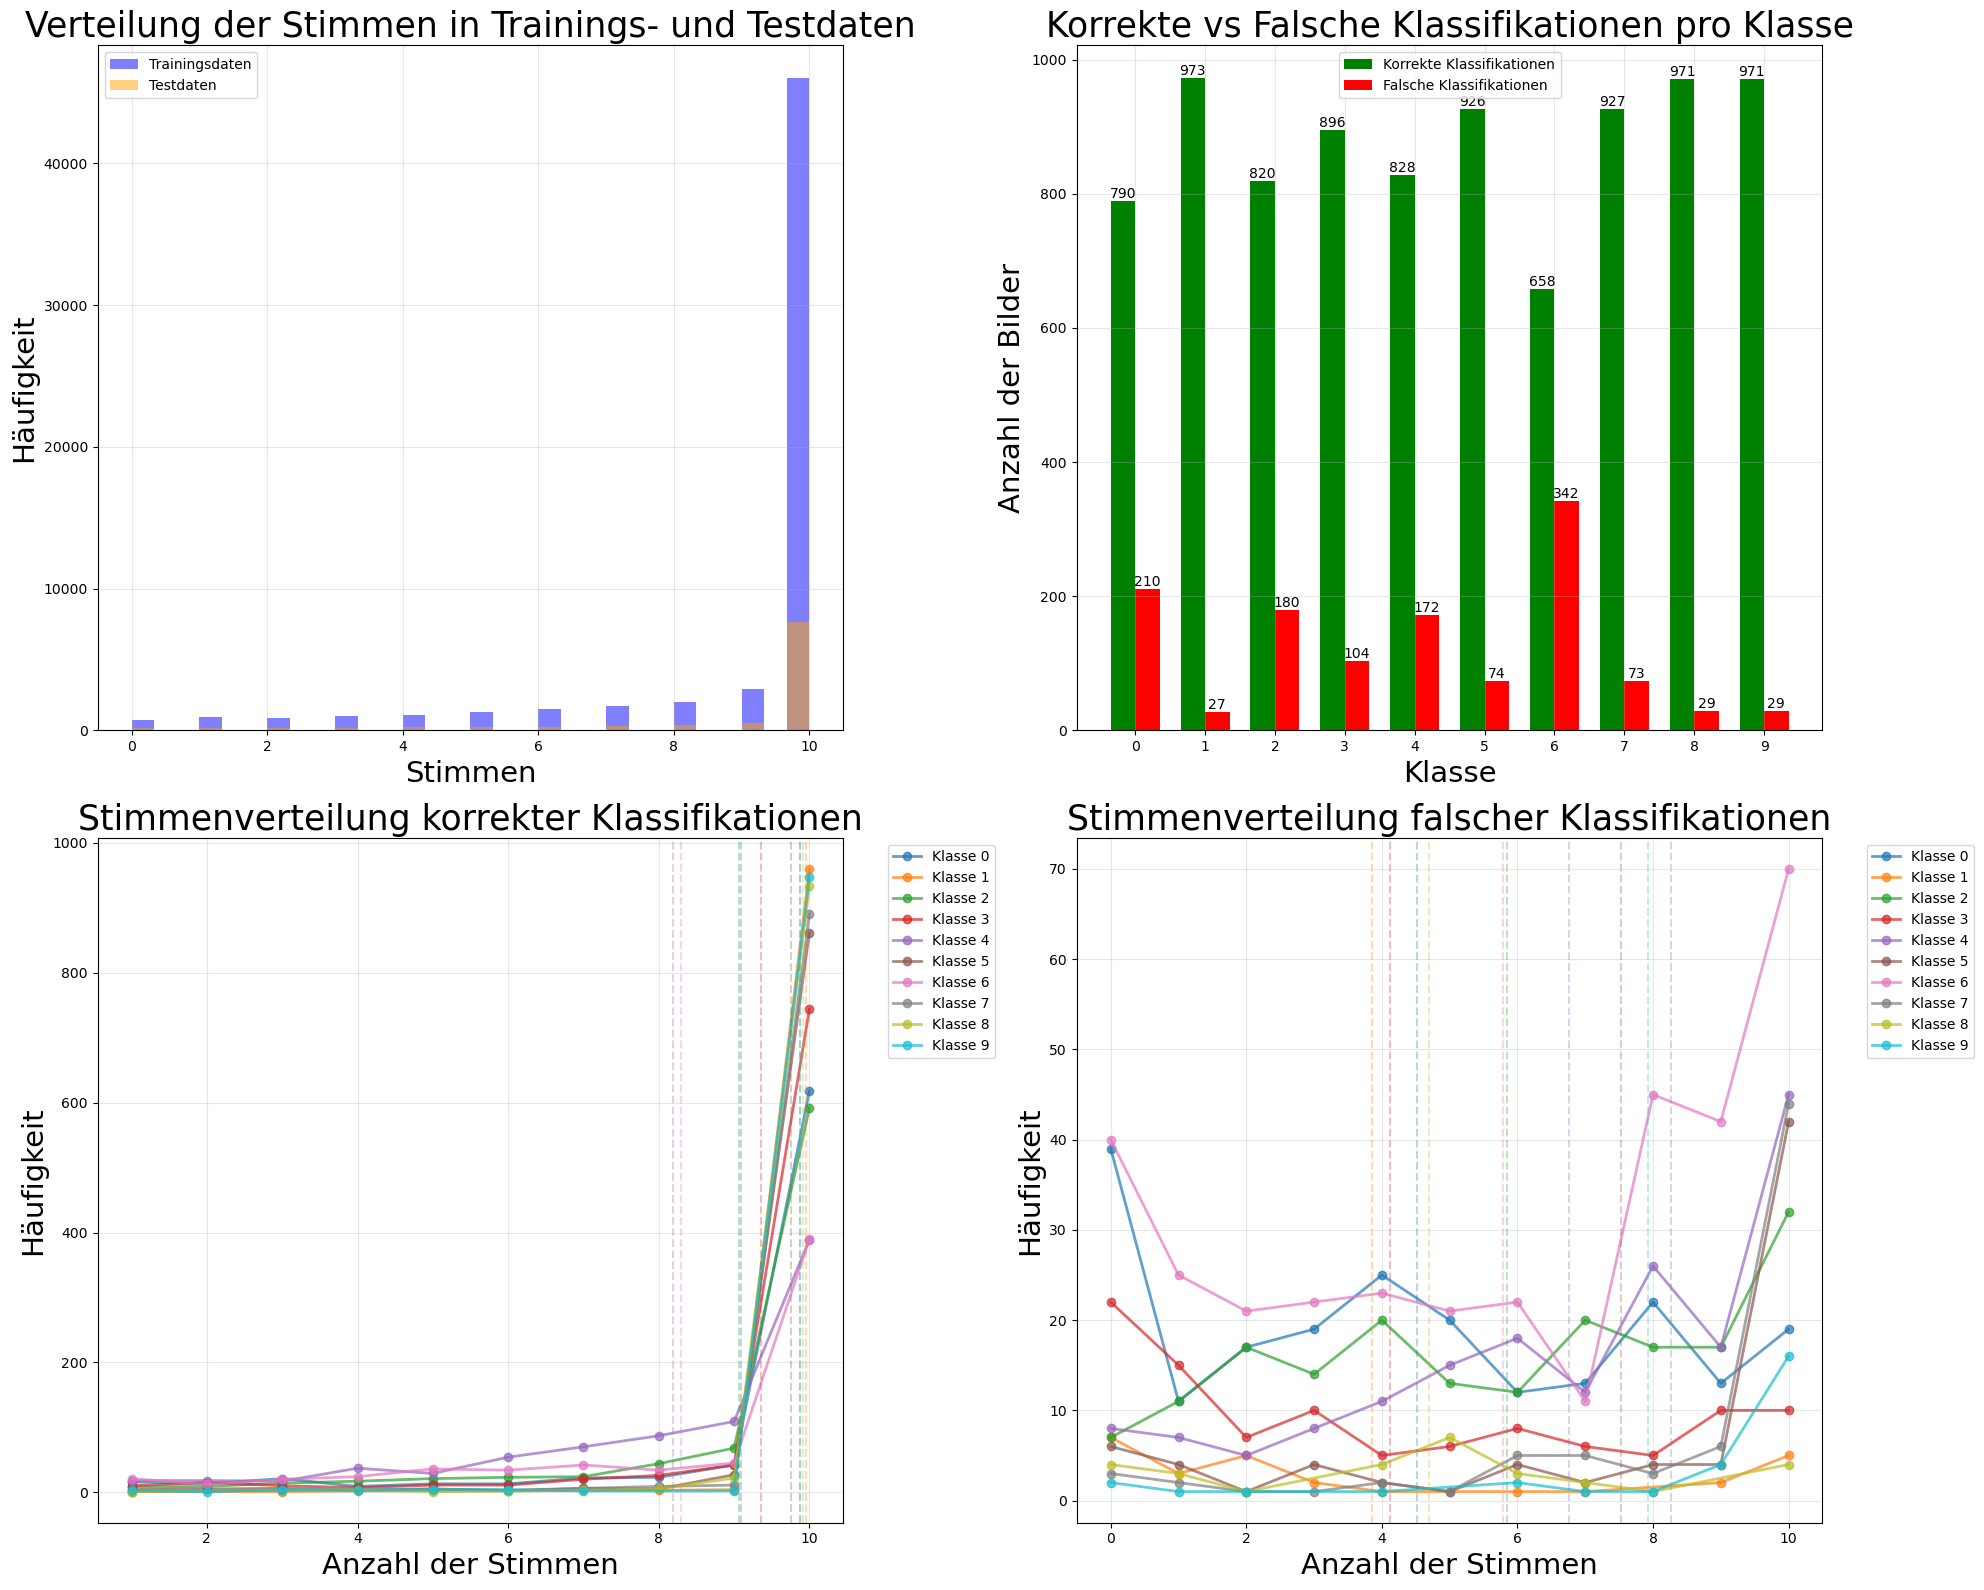

In [58]:
# Create a figure with 2x2 subplots
plt.figure(figsize=(20, 16))


plt.subplot(2, 2, 1)
plt.hist(train_vote_counts, bins=30, alpha=0.5, label='Trainingsdaten', color='blue')
plt.hist(test_vote_counts, bins=30, alpha=0.5, label='Testdaten', color='orange')
plt.xlabel('Stimmen', fontsize=21)
plt.ylabel('Häufigkeit', fontsize=21)
plt.title('Verteilung der Stimmen in Trainings- und Testdaten', fontsize=25)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
x = numpy.arange(len(classes))
width = 0.35
plt.bar(x - width/2, correct_counts, width, label='Korrekte Klassifikationen', color='green')
plt.bar(x + width/2, incorrect_counts, width, label='Falsche Klassifikationen', color='red')
plt.xlabel('Klasse', fontsize=21)
plt.ylabel('Anzahl der Bilder', fontsize=21)
plt.title('Korrekte vs Falsche Klassifikationen pro Klasse', fontsize=25)
plt.xticks(x, classes)
plt.legend()
for i, v in enumerate(correct_counts):
    plt.text(i - width/2, v, str(v), ha='center', va='bottom')
for i, v in enumerate(incorrect_counts):
    plt.text(i + width/2, v, str(v), ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
colors = plt.cm.tab10(numpy.linspace(0, 1, 10))
for i in classes:
    vote_counts = {}
    for vote in class_votes_correct[i]:
        vote_counts[vote] = vote_counts.get(vote, 0) + 1  
    votes_sorted = sorted(vote_counts.keys())
    frequencies = [vote_counts[v] for v in votes_sorted]  
    plt.plot(
        votes_sorted, frequencies,
        '-', linewidth=2, marker='o',
        label=f'Klasse {i}', color=colors[i], alpha=0.7
    )
plt.title('Stimmenverteilung korrekter Klassifikationen', fontsize=25)
plt.xlabel('Anzahl der Stimmen', fontsize=21)
plt.ylabel('Häufigkeit', fontsize=21)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for i in classes:
    if class_votes_correct[i]:
        mean_votes = numpy.mean(class_votes_correct[i])
        plt.axvline(x=mean_votes, color=colors[i], linestyle='--', alpha=0.3)
plt.tight_layout()

plt.subplot(2, 2, 4)
colors = plt.cm.tab10(numpy.linspace(0, 1, 10))
for i in classes:
    vote_counts = {}
    for vote in class_votes_incorrect[i]:
        vote_counts[vote] = vote_counts.get(vote, 0) + 1
    votes_sorted = sorted(vote_counts.keys())
    frequencies = [vote_counts[v] for v in votes_sorted]
    plt.plot(
        votes_sorted, frequencies,
        '-', linewidth=2, marker='o',
        label=f'Klasse {i}', color=colors[i], alpha=0.7
    )
plt.title('Stimmenverteilung falscher Klassifikationen', fontsize=25)
plt.xlabel('Anzahl der Stimmen', fontsize=21)
plt.ylabel('Häufigkeit', fontsize=21)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for i in classes:
    if class_votes_incorrect[i]:
        mean_votes = numpy.mean(class_votes_incorrect[i])
        plt.axvline(x=mean_votes, color=colors[i], linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()